In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
from os.path import expanduser
from pandas import read_csv
from pandas import DataFrame
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from numpy import array, add, divide
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler

## Import data

In [3]:
my_path = 'dataset/amazon.csv'

In [4]:
reviews = read_csv(my_path)
reviews.columns = ['text_review', 'rating']
reviews.head()

,text_review,rating
0,The description and photo on this product need...,3
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5


## Preproccessing

### Puncuation, Noise Removal, Lowercasing and Normalization

In [5]:
reviews['text_review'] = reviews['text_review'].map(simple_preprocess)
reviews.head()

,text_review,rating
0,"[the, description, and, photo, on, this, produ...",3
1,"[this, was, great, book, it, is, well, thought...",5
2,"[am, first, year, teacher, teaching, th, grade...",5
3,"[got, the, book, at, my, bookfair, at, school,...",5
4,"[hi, martine, redman, and, created, this, puzz...",5


### Stop words removal 

In [6]:
def remove_stopwords(sentence_as_list):
    stop_words = set(stopwords.words('english'))
    return [word for word in sentence_as_list if word not in stop_words]
            
            
reviews['text_review'] = reviews['text_review'].map(remove_stopwords)
reviews.head()

,text_review,rating
0,"[description, photo, product, needs, changed, ...",3
1,"[great, book, well, thought, easily, imagine, ...",5
2,"[first, year, teacher, teaching, th, grade, sp...",5
3,"[got, book, bookfair, school, looking, somethi...",5
4,"[hi, martine, redman, created, puzzle, briarpa...",5


In [7]:
# remove blanks
reviews = reviews[reviews['text_review'].map(len) > 0]

In [8]:
text_reviews = reviews['text_review'].values
Y = reviews['rating'].values

## Word Embeddings model creation - Word2Vec

In [9]:
model = Word2Vec(
    window=10,
    min_count=1,
    workers=4
)
model.build_vocab(text_reviews, progress_per=1000)

In [10]:
model.train(text_reviews, total_examples=model.corpus_count, epochs=model.epochs)

(8891552, 9327490)

In [11]:
model.save('./amazon_reviews_trained_word2vec')

In [12]:
model.wv.most_similar('computer')

[('interactv', 0.8299218416213989),
 ('phone', 0.8208297491073608),
 ('video', 0.8087035417556763),
 ('dvd', 0.7969558238983154),
 ('tv', 0.773113489151001),
 ('cd', 0.7661594748497009),
 ('click', 0.7653779983520508),
 ('joystick', 0.7540054321289062),
 ('desk', 0.753466784954071),
 ('camera', 0.7507612109184265)]

In [13]:
model.wv.similarity(w1='python', w2='language')

0.65334404

### Pair words to embeddings

In [14]:
word_vec = dict({})
for key in model.wv.index_to_key:
    word_vec[key] = model.wv[key]

### Create document vectors

In [15]:
docVec = []
# for every review
for i in range(len(text_reviews)):
    sentVect = array(100)
    # for each word in review
    for j in range(len(text_reviews[i])):
        word = text_reviews[i][j]
        if word in word_vec.keys():
            # vector addition of the words in the text
            sentVect = add(sentVect, word_vec[word])
            
    # normalize vector
    sentVect = divide(sentVect, len(text_reviews[i]))
    docVec.append(sentVect)

In [16]:
doc_vectors = DataFrame(docVec)
doc_vectors['rating'] = Y
doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,rating
0,9.026176,9.651213,8.763224,8.771465,9.281157,8.919657,8.686464,10.676805,8.982865,9.419347,...,8.605595,8.712249,9.203014,9.233106,9.107856,9.010648,8.602348,9.027303,9.310956,3
1,4.145932,4.401742,3.253907,4.501170,3.576679,3.604283,3.985062,4.195835,3.670390,3.686462,...,4.189379,3.047664,4.004392,4.318831,3.746527,4.458848,3.800182,3.914139,3.682969,5
2,2.119791,2.435576,1.981751,2.152745,1.788873,1.687862,2.125362,2.287931,1.378933,1.601773,...,2.079860,1.454820,1.933541,1.985494,1.918369,2.086721,1.782287,1.216375,1.748235,5
3,2.636468,2.609632,2.160556,2.674132,2.053840,2.432150,2.559368,2.677409,1.605732,2.164188,...,2.244016,2.036463,2.397319,2.261201,1.996912,2.460735,1.850936,1.952041,1.853505,5
4,1.477969,2.006236,1.190415,1.771404,1.415149,1.569226,1.630453,1.907989,1.457947,1.441420,...,1.645538,0.960407,1.380754,1.512646,1.540808,1.916054,1.498982,1.207430,1.558502,5


### Class Sample distribution

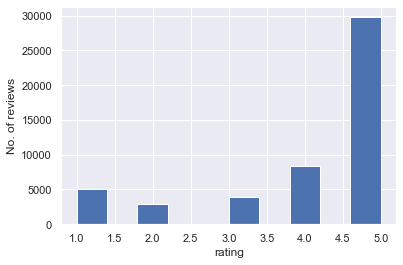

In [17]:
plt.hist(doc_vectors['rating'])
plt.xlabel('rating')
plt.ylabel('No. of reviews')
plt.show()

### Balance class sample weight

In [18]:
# data are biased on '5' rating, so we generate new samples
# by randomly sampling with replacement of the currently available samples 
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(doc_vectors.drop(['rating'], axis=1), doc_vectors['rating'])
y_ros.value_counts()

3    29772
5    29772
4    29772
1    29772
2    29772
Name: rating, dtype: int64

### Split to train - test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size=0.2)

### Apply RandomForest Classifier

In [20]:
randomForest = RandomForestClassifier(n_estimators=20, random_state=42)
randomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [21]:
randomForest.score(X_test, y_test)

0.9547225581082897

In [22]:
y_pred = randomForest.predict(X_test)

### Confusion Matrix

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5])
cm

array([[5920,    0,    3,    2,   13],
       [   0, 5907,    6,    1,    3],
       [   1,    0, 5964,    8,    2],
       [  21,    7,   17, 5709,  239],
       [ 248,   58,  108,  611, 4924]], dtype=int64)

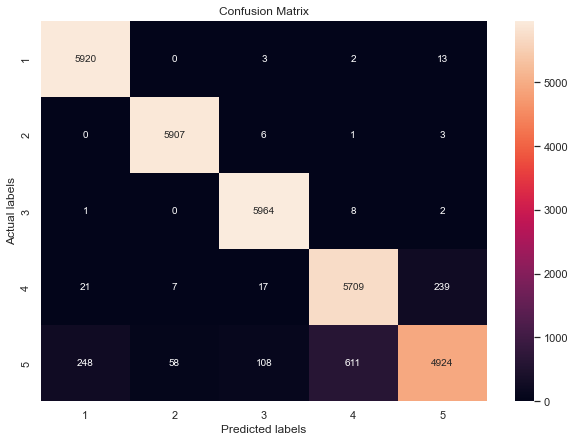

In [24]:
%matplotlib inline

plt.figure(figsize=(10,7))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([1, 2, 3, 4, 5]); ax.yaxis.set_ticklabels([1, 2, 3, 4, 5]);
plt.show()

###  f1 score, precision and recall 

In [25]:
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.955
Recall: 0.955
F1 Score: 0.955
Accuracy: 0.955
